## TensorFlow 2 ResNet 模型训练 


### 数据集准备

In [1]:
cate = "classified"
# 数据路径
dataset_path = f"data/{cate}"
# 训练集路径
train_dataset_path = f"{dataset_path}/train"
# 验证集路径
val_dataset_path = f"{dataset_path}/val"

In [2]:
# 划分数据集（首次执行）
from dataset import Dataset
# 训练和验证集比例
train_ratio = 0.9

data_loader = Dataset(dataset_path, train_ratio=train_ratio) 

In [3]:
# 提取类别名称
import os
class_name = list(
    filter(
        lambda x: not x.startswith(".")
        and os.path.isdir(os.path.join(train_dataset_path, x)),
        os.listdir(train_dataset_path),
    )
)
print(f"类别总数：{len(class_name)}")

类别总数：167


### 模型准备

In [4]:
model = "ResNet50"
model_name = f"{model}_{cate}"
model_path = f"models/{model}/{model_name}.h5"

In [5]:
from tensorflow import keras as keras
from PIL import Image

import tensorflow as tf
import numpy as np

keras.backend.clear_session()  # For easy reset of notebook state.

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(devices=gpus[0], device_type="GPU")

In [6]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(include_top=False, weights='imagenet', classes=1000)
base_model.trainable = False

In [7]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model

x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x) 
x = Dense(1024, activation='relu')(x) 
y = Dense(len(class_name), activation='softmax')(x) #final layer with softmax activation

model = Model(inputs=base_model.input, outputs=y, name=model_name)

In [13]:
# model.summary()

### 定义优化器和损失函数

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

### 数据生成器

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image


train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dataset_path,
        target_size=(224,224),
        classes=class_name,
        color_mode='rgb',
        batch_size=128,
        class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
        val_dataset_path,
        target_size=(224,224),
        classes=class_name,
        color_mode='rgb',
        batch_size=128,
        class_mode='categorical')

Found 8185 images belonging to 167 classes.
Found 984 images belonging to 167 classes.


### 设置 EarlyStoping 条件

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="loss", patience=3, verbose=1)

### 开始训练

In [ ]:
history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        callbacks=earlystop)

Epoch 1/20
   1497/Unknown - 399s 266ms/step - loss: 0.9325 - accuracy: 0.7445

### 保存模型

In [ ]:
model.save(model_path)

### 计算 Top-1 / Top-5 Acc


In [ ]:
# 加载一批图像
def load_image_list(test_dir):
    image_tensor_list = []    
    image_list = [os.path.join(test_dir, img_name) for img_name in os.listdir(test_dir)]
    for image_path in image_list:
        img = image.load_img(image_path, target_size=(224, 224))
        img_tensor = image.img_to_array(img)                    
        img_tensor = np.expand_dims(img_tensor, axis=0)         
        img_tensor /= 255.
        image_tensor_list.append(img_tensor.reshape(224,224,3))

    
    return np.asarray(image_tensor_list)

In [ ]:
top1_corrects = 0
top5_corrects = 0
total = 0
for idx, cls_name in enumerate(class_name):
    test_dir = f"{test_dataset_path}/{cls_name}"
    img_list = load_image_list(test_dir)
    if len(img_list) > 0:
        preds = model.predict_on_batch(img_list)
        total += len(preds)    
        for pred in preds:          
            top_ids = pred.argsort()[-5:][::-1]
#             result = class_name[np.argmax(pred)]
            if idx == top_ids[0]:
                top1_corrects += 1
            if idx in top_ids:
                top5_corrects += 1

print(f"Top-1 Acc: {top1_corrects/total}")
print(f"Top-5 Acc: {top5_corrects/total}")
print(f"Total testing images: {total}")


### 加载模型

In [ ]:
model = keras.models.load_model(model_path)

### 单张预测

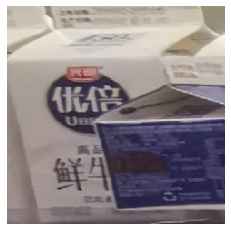

['优倍']


In [72]:
from matplotlib import pyplot as plt

def load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255.                                      

    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

    return img_tensor

img_path = 'data/classified/val/RIO蓝/1103_6610.jpg'
img_tensor = load_image(img_path)

pred = model.predict(img_tensor)

# print([[class_name[i], prob] for i, prob in enumerate(pred[0])])
print([class_name[np.argmax(prob)] for prob in pred])

In [122]:
# 批量预测
img_list = load_image_list("diwen/test/优倍/")
preds = model.predict_on_batch(img_list)
results = [class_name[np.argmax(prob)] for prob in preds]
print(results)

['优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍', '优倍']
